In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")

from os import path
from glob import glob
from tqdm import tqdm

from matplotlib.lines import Line2D
from matplotlib import colors

from scipy.interpolate import interp1d
from scipy.optimize import ridder
from scipy.integrate import quad

import os
os.environ["ASTERIA"] = "/Users/jlazar/research/ASTERIA"
import sys
sys.path.append("/Users/jlazar/research/ASTERIA/python/")
from ic_sn_hnl import units, parameterized_flux_from_files, ParameterizedFlux
from ic_sn_hnl.flux.parametrize_flux import Params, deserialize

from typing import List, Tuple, Optional, Dict, Any

In [3]:
from ic_sn_hnl.flux.parametrize_flux import massage_infile

In [5]:
# idx_min, idx_max = 1, 133

# # arr = arr_full[100]
# flux = arr[idx_min:idx_max, 2]
# e = arr[idx_min:idx_max, 1]

# i = interp1d(e, flux)
# norm, err = quad(i, e.min(), e.max())

# plt.plot(e, flux*6)
# plt.show()

# print(norm)
# plt.plot(e, flux / norm)
# plt.show()

# plt.plot(e, e * flux / norm)
# plt.show()

# plt.plot(e, e**2 * flux / norm)
# plt.show()

In [6]:
TMAX = 100 * units["second"]
TMIN = 1e-2 * units["second"]
TMINS = np.logspace(np.log10(TMIN), np.log10(TMAX), 201)
DTS = np.linspace(0.001, 5, 401) * units["second"]
TMAXS = np.logspace(np.log10(TMIN), np.log10(TMAX), 201)

In [7]:
with h5.File("data/SM_flux.h5", "r") as h5f:
    sm_flux = deserialize(h5f["SM_flux_thin_10_0"])

In [8]:
fs = glob("./data/majoron/from_yingying/*")
force = False

fs

for f in tqdm(fs):
    x = f.split("/")[-1].replace(".csv", "_div6.npy")
    outfile = os.path.abspath(f"./data/majoron/per_flavor/{x}")
    print(outfile)
    if path.exists(outfile) and not force:
        continue
    arr = np.genfromtxt(f, delimiter=",")
    
    outarr = np.zeros(arr.shape)
    outarr[:, 0] = arr[:, 0]
    outarr[:, 1] = arr[:, 1]
    outarr[:, 2] = arr[:, 2] / 6
    
    if not np.all(arr[:, 0]==outarr[:, 0]):
        raise ValueError("Times are messed up")
    if not np.all(arr[:, 1]==outarr[:, 1]):
        raise ValueError("Energies are messed up")
    r = arr[:, 2] / outarr[:, 2]
    if not np.all(r[~np.isnan(r)]==6):
        raise ValueError("Fluxes are messed up")
    np.savetxt(outfile, outarr, delimiter=",")

  0%|          | 0/15 [00:00<?, ?it/s]

/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-200MeV-gn11dot2-100s-nf_div6.npy
/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-10MeV-gn10dot8-100s-nf_div6.npy
/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-10MeV-gn10dot4-100s-nf_div6.npy
/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-100MeV-gn11dot6-100s-nf_div6.npy
/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-200MeV-gn11dot4-100s-nf_div6.npy
/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-200MeV-gn11dot8-100s-nf_div6.npy
/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-200MeV-gn11dot1-100s-nf_div6.npy
/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-200MeV-gn11dot6-100s-nf_div6.npy
/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-100MeV-gn11dot2-100s-nf_div6.npy
/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-100MeV-gn11dot1-100s-nf_div6.npy
/U

/var/folders/4q/ncd7kk_j2t9_syxd3gmst9mc0000gn/T/ipykernel_20053/1933906341.py:23: RuntimeWarning: invalid value encountered in divide
  r = arr[:, 2] / outarr[:, 2]
100%|██████████| 15/15 [00:59<00:00,  3.94s/it]

/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-100MeV-gn11dot4-100s-nf_div6.npy
/Users/jlazar/research/ic_sn_bsm/data/majoron/per_flavor/dphi-dEdt-10MeV-gn10dot6-100s-nf_div6.npy


In [10]:
fs = glob("./data/majoron/per_flavor/*_div6.csv")
h5fname = "data/majoron/serialized_fluxes.h5"
thin = 100
force = False

if not os.path.exists(h5fname):
    with h5.File(h5fname, "w") as _:
        pass

for f in fs:
    desc = f.split("/")[-1].replace(".csv", "")
    log_coupling = float(f"-{desc.split('-')[3][2:].replace('dot', '.')}")
    mass = float(desc.split('-')[2].replace("MeV", ""))
    print(f"{desc}_0")
    with h5.File(h5fname, "r") as h5f:
        if f"{desc}_0" in h5f.keys() and not force:
            continue
    flux = parameterized_flux_from_files(f, f, f, 10*units["kpc"], thin=thin)
    flux.serialize(h5fname, groupname=desc, mass=mass, log_coupling=log_coupling, thin=thin)


dphi-dEdt-100MeV-gn11dot4-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot8-100s-nf_div6_0
dphi-dEdt-10MeV-gn10dot6-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot6-100s-nf_div6_0
dphi-dEdt-10MeV-gn10dot8-100s-nf_div6_0
dphi-dEdt-100MeV-gn11dot1-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot2-100s-nf_div6_0
dphi-dEdt-100MeV-gn11dot6-100s-nf_div6_0
dphi-dEdt-10MeV-gn10dot4-100s-nf_div6_0
dphi-dEdt-10MeV-gn10-100s-nf_div6_0
dphi-dEdt-1MeV-gn10dot6-100s-nf_div6_0
dphi-dEdt-100MeV-gn11dot2-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot1-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot4-100s-nf_div6_0
dphi-dEdt-100MeV-gn11dot8-100s-nf_div6_0


In [11]:
def likelihood(sig_hits, sm_hits, bg_hits):
    n_obs = (bg_hits + sm_hits).sum()
    n_exp = (sig_hits + bg_hits + sm_hits).sum()
    llh = 2 * (n_exp - n_obs)
    if n_obs > 0:
        llh += 2 * n_obs * np.log(n_obs / n_exp)
    return llh

In [12]:
def find_significance_matrix(sig_hits, sm_hits, bg_hits, times, tmins=TMINS, dts=DTS):
    significance = np.full(tmins.shape + dts.shape, np.nan)

    for idx, tmin in enumerate(tmins):
        for jdx, dt in enumerate(dts):
            m = np.logical_and(tmin < times, times < tmin+dt)
            if not m.sum():
                continue
            significance[idx, jdx] = likelihood(sig_hits[m], sm_hits[m], bg_hits[m])
    return significance, tmins, dts

dphi-dEdt-100MeV-gn11-100s-nf_div6_0
283562.8775626008
151169075.5683882

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


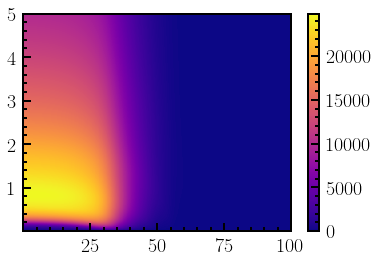

dphi-dEdt-100MeV-gn11dot1-100s-nf_div6_0
180364.57749633977
151201692.49126822

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


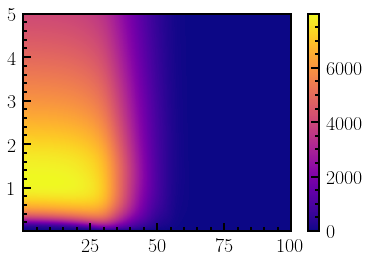

dphi-dEdt-100MeV-gn11dot2-100s-nf_div6_0
118797.40657281414
151172150.76802564

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


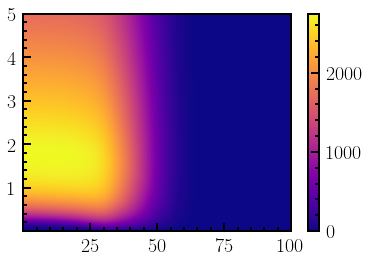

dphi-dEdt-100MeV-gn11dot4-100s-nf_div6_0
49382.44401933151
151194695.96787426

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


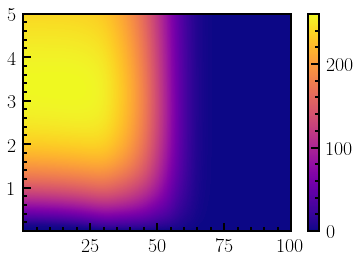

dphi-dEdt-100MeV-gn11dot6-100s-nf_div6_0
19865.98719113393
151147602.0575796

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


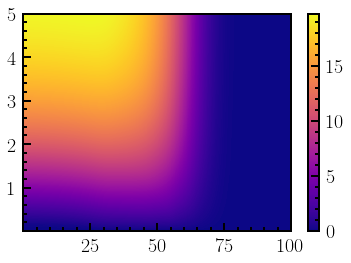

dphi-dEdt-100MeV-gn11dot8-100s-nf_div6_0
7844.279159578505
151190400.43044662

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


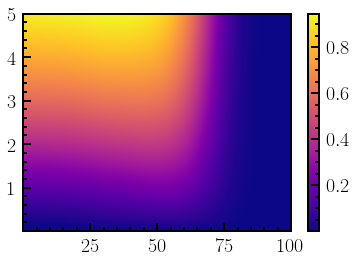

dphi-dEdt-100MeV-gn12-100s-nf_div6_0
3157.895911106843
151197041.75579154

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


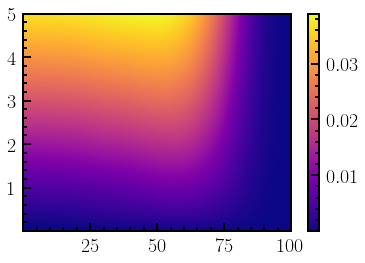

dphi-dEdt-10MeV-gn10-100s-nf_div6_0
296193.65205423743
151148423.12966228

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


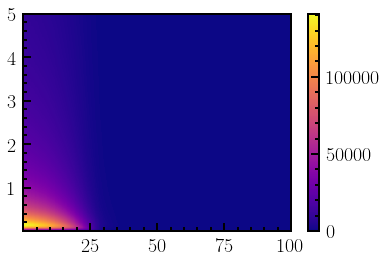

dphi-dEdt-10MeV-gn10dot4-100s-nf_div6_0
33058.852111035354
151156758.6252447

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


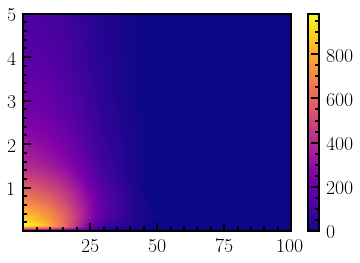

dphi-dEdt-10MeV-gn10dot6-100s-nf_div6_0
9154.229914227204
151171829.18635947

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


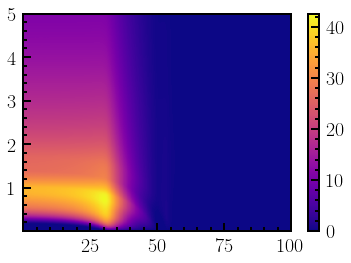

dphi-dEdt-10MeV-gn10dot8-100s-nf_div6_0
7453.6479448996015
151133435.50246137

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


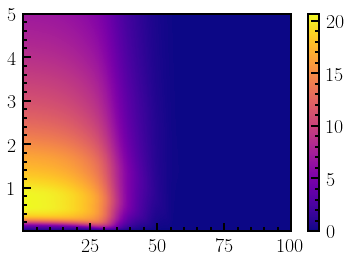

dphi-dEdt-1MeV-gn10-100s-nf_div6_0
3234.342660217716
151149111.1686724

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


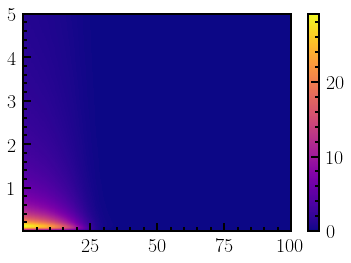

dphi-dEdt-1MeV-gn10dot6-100s-nf_div6_0
149.14651803969969
151175421.68682882

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


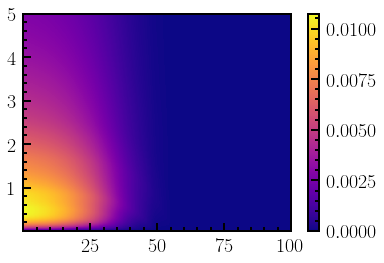

dphi-dEdt-1MeV-gn9-100s-nf_div6_0
230179.94425484596
151161597.2204814

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


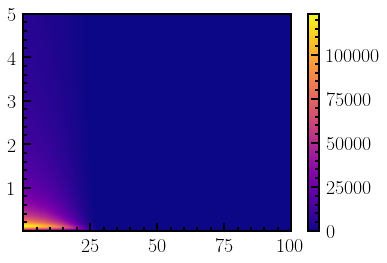

dphi-dEdt-200MeV-gn11-100s-nf_div6_0
535868.3811724618
151181993.1770723

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


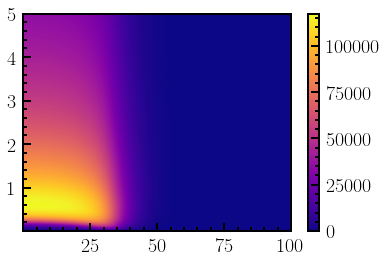

dphi-dEdt-200MeV-gn11dot1-100s-nf_div6_0
371583.9102466374
151202351.8704057

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


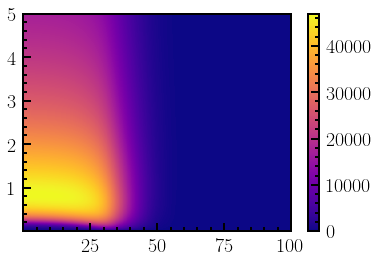

dphi-dEdt-200MeV-gn11dot2-100s-nf_div6_0
249021.2722615416
151173484.95256498

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


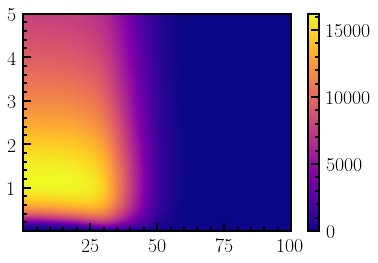

dphi-dEdt-200MeV-gn11dot4-100s-nf_div6_0
105623.82882137016
151182856.29895487

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


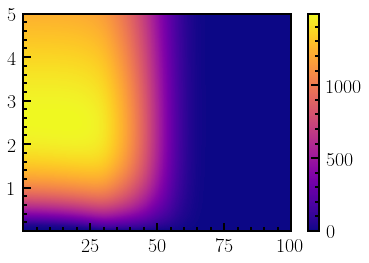

dphi-dEdt-200MeV-gn11dot6-100s-nf_div6_0
42958.75917001801
151170460.39400294

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


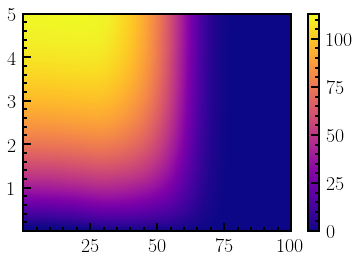

dphi-dEdt-200MeV-gn11dot8-100s-nf_div6_0
17055.2134503033
151158974.62907156

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


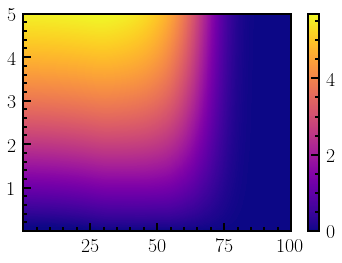

dphi-dEdt-200MeV-gn12-100s-nf_div6_0
6557.544869246717
151205021.95239863

[ -1.     -0.999  -0.998 ...  99.999 100.    100.001]


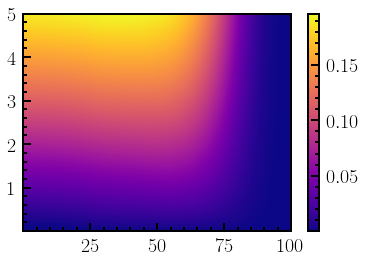

In [40]:
sm_t, sm_hits = sm_flux.get_hits(tmax=100 * units["second"])
out = {}

with h5.File("data/majoron/serialized_fluxes.h5", "r") as h5f:
    for key in h5f.keys():
        print(key)
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", ""))
        if mass not in out:
            out[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}")
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        print(bsm_hits.sum())
        print(bg_hits.sum())
        print()
        
        print(bsm_t / units["second"])
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
        m = ~np.isnan(significance)
        im = plt.imshow(
            significance.T[::-1],
            aspect="auto",
            extent=[
                TMINS[0] /units["second"],
                TMINS[-1] /units["second"],
                DTS[0] /units["second"],
                DTS[-1] /units["second"],
            ]
        )
        cbar = plt.colorbar(im)
        plt.show()
        
        out[mass].append((coupling, significance[m].max()))
        # break

In [43]:
model1 = "dphi-dEdt-10MeV-gn10dot8-100s-nf_div6"
model2 = "dphi-dEdt-100MeV-gn11dot8-100s-nf_div6"


In [44]:
a = np.load(f"data/majoron/per_flavor/{model1}.npy")
b = np.load(f"data/majoron/per_flavor/{model2}.npy")
c = np.load(f"data/fluxactivenuX_div4.npy")
with h5.File("./data/majoron/serialized_fluxes.h5", "r") as h5f:
    flux1 = deserialize(h5f[f"{model1}_0"])
    flux2 = deserialize(h5f[f"{model2}_0"])
    

In [94]:
x = find_significance_matrix(bsm_hits2, sm_hits, bg_hits, bsm_t1)

In [86]:
np.argwhere(x[0]==x[0].max())

array([[ 1, 46],
       [ 2, 46]])

In [90]:
x[1][1] / units["second"]

0.010471285480509003

In [92]:
x[2][46] / units["second"]

0.575885

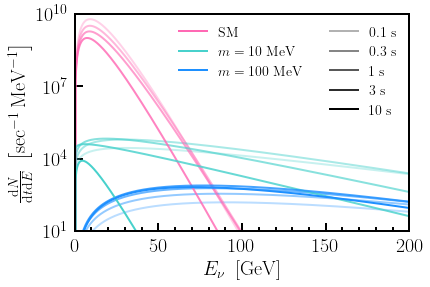

In [50]:
es = np.linspace(0, 200, 400)
ts = np.array([0.1, 0.3, 1, 3, 10]) * units["second"]

c1 = "mediumturquoise"
c2 = "dodgerblue"
c3 = "hotpink"

alphamin = 0.3
alphamax = 1.0

handles = [
    Line2D([], [], color=c3, label=r"SM"),
    Line2D([], [], color=c1, label=r"$m=10~\mathrm{MeV}$"),
    Line2D([], [], color=c2, label=r"$m=100~\mathrm{MeV}$"),
    Line2D([], [], alpha=0.0),
    Line2D([], [], alpha=0.0),
    Line2D([], [], color="k", alpha=0/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.1}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=1/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{0.3}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=2/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{1}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=3/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{3}~\mathrm{s}$"),
    Line2D([], [], color="k", alpha=4/4*(alphamax - alphamin) + alphamin, label=r"$\mathrm{10}~\mathrm{s}$"),
]


for idx, t in enumerate(ts):
    alpha = idx / (len(ts)-1) * (alphamax - alphamin) + alphamin
    # alpha = (len(ts) - idx - 1) / (len(ts)-1) * (alphamax - alphamin) + alphamin
    
    try:
        plt.plot(
            es,
            sm_flux.get_flux(t, es, 0),
            color=colors.to_rgb(c3) + (alpha,)   
        )

    except ValueError:
        pass
    plt.plot(
        es,
        flux1.get_flux(t, es, 0),
        color=colors.to_rgb(c1) + (alpha,)
    )
    plt.plot(
        es,
        flux2.get_flux(t, es, 0),
        color=colors.to_rgb(c2) + (alpha,)
    )

plt.ylabel(
    r"$\frac{\mathrm{d}N}{\mathrm{d}t\mathrm{d}E}~\left[\mathrm{sec}^{-1}\,\mathrm{MeV}^{-1}\right]$",
    fontsize=20
)
plt.xlabel(
    r"$E_{\nu}~\left[\mathrm{GeV}\right]$"
)
plt.ylim(1e1, 1e10)
plt.xlim(es.min(), es.max())
plt.semilogy()
plt.legend(handles=handles, ncol=2, fontsize=14, framealpha=0)
plt.savefig("./figures/majoran_fluxes.pdf")
plt.show()

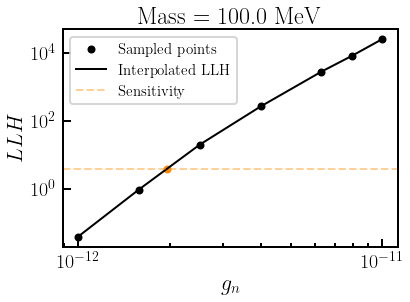

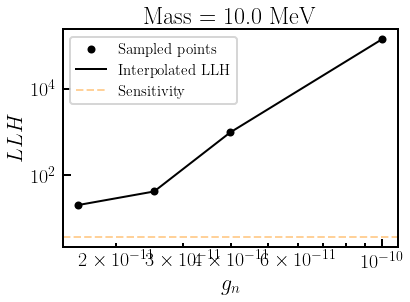

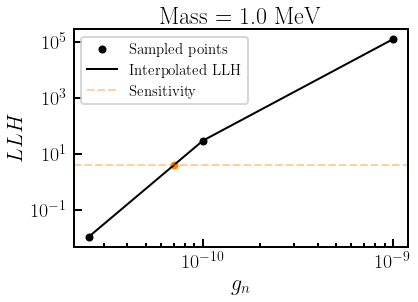

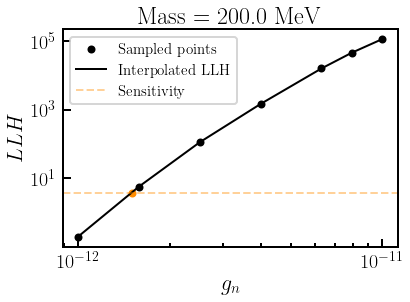

In [42]:
a = []
for k, v in out.items():
    
    cs, ss = 10**np.array([x[0] for x in v]), np.array([x[1] for x in v])
    sorter = np.argsort(cs)    
    cs, ss = cs[sorter], ss[sorter]
    
    interp = interp1d(np.log(cs), np.log(ss))
    f = lambda lc: np.exp(interp(lc)) - 3.841
    try:
        res = ridder(f, np.log(cs[0]), np.log(cs[-1]))
        plt.scatter(np.exp(res), np.exp(interp(res)), color="darkorange")
    except ValueError:
        # pass
        res = np.nan

    a.append((k, np.exp(res)))

    plt.scatter(cs, ss, color="k", label="Sampled points")
    plt.plot(cs, ss, color="k", label="Interpolated LLH")
    plt.xlabel(r"$g_{n}$", fontsize=22)
    plt.ylabel(r"$LLH$", fontsize=22)
    plt.axhline(3.841, label=r"Sensitivity", ls="--", color="darkorange", alpha=0.4)
    plt.title(f"Mass = {k} MeV")
    plt.loglog()
    # plt.ylim()
    plt.legend(fontsize=15)
    plt.savefig(f"figures/majoran_sensitivities_{k}.pdf")
    plt.show()
a = sorted(a, key=lambda x: x[0])

In [58]:
with h5.File("./data/majoron/serialized_fluxes.h5", "r") as h5f:
    flux1 = deserialize(h5f[f"{model1}_0"])
    flux2 = deserialize(h5f[f"{model2}_0"])

    bsm_t1, bsm_hits1 = flux1.get_hits(
        model_file="magnetic_moment.txt",
        tmax=100 * units["second"]
    )

    bsm_t2, bsm_hits2 = flux2.get_hits(
        model_file="magnetic_moment.txt",
        tmax=100 * units["second"]
    )

    bg_hits = flux1.get_background(
        shape=bsm_hits.shape,
        model_file="magnetic_moment.txt",
        tmax=100 * units["second"]
    )

In [60]:
bsm_t2 / units["second"]

array([ -1.   ,  -0.999,  -0.998, ...,  99.999, 100.   , 100.001])

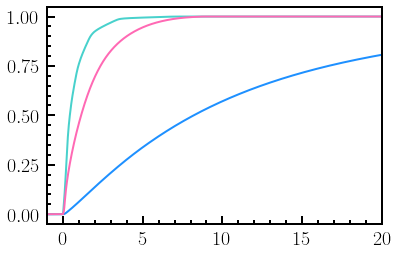

In [93]:
_, ax = plt.subplots()

ax.plot(
    bsm_t2 / units["second"],
    np.cumsum(bsm_hits2) / bsm_hits2.sum(),
    c=c2
)
ax.plot(
    bsm_t1 / units["second"],
    np.cumsum(bsm_hits1) / bsm_hits1.sum(),
    c=c1
)
ax.plot(
    sm_t / units["second"],
    np.cumsum(sm_hits) / sm_hits.sum(),
    c=c3
)

ax.set_xlim(-1, 20)

plt.show()

In [16]:
def make_flux_heatmap(
    flux: ParameterizedFlux,
    es: List[float] = np.logspace(0, 3, 200),
    ts: List[float] = np.linspace(0.01, 8, 500),
    cmap: Optional[str] = "Purples",
    vmin: Optional[float] = None,
    ax: Optional[plt.Axes] = None,
    text: Optional[Tuple[float, float, str]] = None,
    textkwargs: Optional[Dict[str, Any]] = None,
    cbarticks: Optional[List[float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
):

    out = np.full(es.shape+ts.shape, np.nan)
    for idx, t in enumerate(ts):
        # out[:, idx] = np.power(es, 2) * flux.get_flux(t, es)
        out[:, idx] = np.power(es, 2) * flux.get_flux(t, es, 0)

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))

    im = ax.imshow(
        np.log10(out.T[::-1]),
        vmin=vmin,
        extent=[
            np.log10(es)[0],
            np.log10(es)[-1],
            ts[0],
            ts[-1]
        ],
        aspect="auto",
        cmap=cmap
    )
    
    ax.set_xlabel(r"$E_{\nu}~\left[\mathrm{MeV}\right]$")
    ax.tick_params(which="minor", width=0)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels([r"$10^{0}$", r"$10^{1}$", r"$10^{2}$", r"$10^{3}$"])

    ax.set_ylabel(r"$t - t_{\mathrm{bounce}}~\left[\mathrm{s}\right]$")
    if ylim is not None:
        ax.set_ylim(ylim)
    
    if text is not None:
        ax.text(*text, textkwargs)

    cbar = plt.colorbar(im, label=r"$E_{\nu}^{2}\,\Phi_{\nu}~\left[\mathrm{MeV}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\right]$")
    if cbarticks is not None:
        cbar.set_ticks(cbarticks)
        cbar.set_ticklabels([r"$10^{%d}$" % x for x in cbarticks])

    return ax
    # plt.show()

In [6]:
arr = np.genfromtxt("./data/majoron/per_flavor/dphi-dEdt-100MeV-gn12-100s-nf_div6.csv", delimiter=",")

In [7]:
with h5.File("data/majoron/serialized_fluxes.h5", "r") as h5f:
    # print(h5f.keys())
    key = "dphi-dEdt-100MeV-gn12-100s-nf_div6_0"
    flux = deserialize(h5f[key])

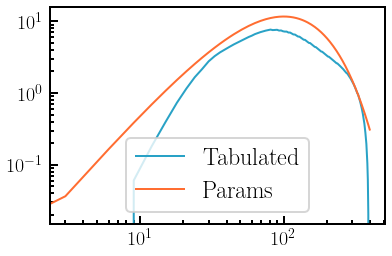

/var/folders/4q/ncd7kk_j2t9_syxd3gmst9mc0000gn/T/ipykernel_46136/4035016802.py:19: RuntimeWarning: divide by zero encountered in divide
  flux.get_flux(0.021, arr[offset * 134: (offset+1)*134, 1], 0) / arr[offset * 134: (offset+1)*134, 2]
/var/folders/4q/ncd7kk_j2t9_syxd3gmst9mc0000gn/T/ipykernel_46136/4035016802.py:19: RuntimeWarning: invalid value encountered in divide
  flux.get_flux(0.021, arr[offset * 134: (offset+1)*134, 1], 0) / arr[offset * 134: (offset+1)*134, 2]


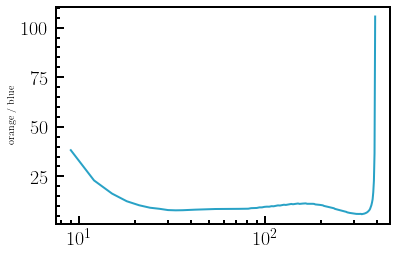

In [8]:
offset = 21
plt.plot(
    arr[offset * 134: (offset+1)*134, 1],
    arr[offset * 134: (offset+1)*134, 2],
    label="Tabulated"
)
plt.plot(
    arr[offset * 134: (offset+1)*134, 1],
    flux.get_flux(0.021, arr[offset * 134: (offset+1)*134, 1], 0) / 6,
    label="Params"
)

plt.legend()
plt.loglog()
plt.show()

plt.plot(
    arr[offset * 134: (offset+1)*134, 1],
    flux.get_flux(0.021, arr[offset * 134: (offset+1)*134, 1], 0) / arr[offset * 134: (offset+1)*134, 2]
)
plt.ylabel("orange / blue")
plt.semilogx()
plt.show()

dphi-dEdt-100MeV-gn11-100s-nf_div6_0


/Users/jlazar/research/ic_sn_bsm/ic_sn_hnl/flux/parametrize_flux.py:511: RuntimeWarning: invalid value encountered in scalar divide
  a = L / e_exp
/Users/jlazar/research/ic_sn_bsm/ic_sn_hnl/flux/parametrize_flux.py:513: RuntimeWarning: divide by zero encountered in divide
  phi_f = lambda e: a * np.power(e / e_exp, alpha) * np.exp(-(alpha+1) * e / e_exp)
/var/folders/4q/ncd7kk_j2t9_syxd3gmst9mc0000gn/T/ipykernel_32095/1992483723.py:23: RuntimeWarning: divide by zero encountered in log10
  np.log10(out.T[::-1]),


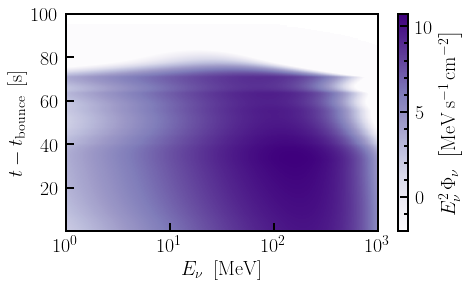

dphi-dEdt-100MeV-gn12-100s-nf_div6_0


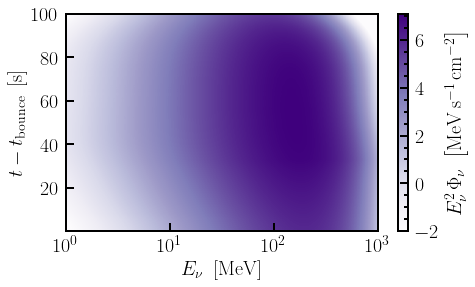

dphi-dEdt-100MeV-gn11dot4-100s-nf_div6_0


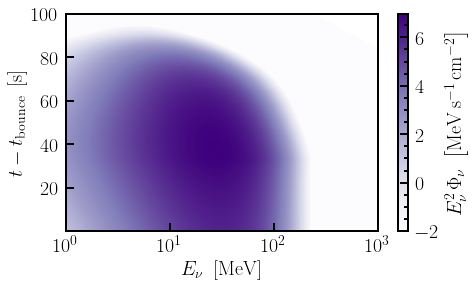

In [30]:
sm_t, sm_hits = sm_flux.get_hits()
out = {}

with h5.File("data/majoron/serialized_fluxes.h5", "r") as h5f:
    # print(h5f.keys())
    for key in "dphi-dEdt-100MeV-gn11-100s-nf_div6_0 dphi-dEdt-100MeV-gn11dot4-100s-nf_div6_0 dphi-dEdt-100MeV-gn12-100s-nf_div6_0".split():
        print(key)
        
        # key_split = key.split("_")[0].split("-")
        # mass = float(key_split[2].replace("MeV", ""))
        # if mass not in out:
        #     out[mass] = []
        # coupling = float(f"-{key_split[3][2:].replace('dot', '.')}")
        flux = deserialize(h5f[key])
        ax = make_flux_heatmap(flux, ts=TMINS / units["second"], vmin=-2)
        plt.show()
        
#         bsm_t, bsm_hits = flux.get_hits(model_file="magnetic_moment.txt")
#         bg_hits = flux.get_background(
#             shape=bsm_hits.shape,
#             model_file="magnetic_moment.txt"
#         )
        
        
        
#         plt.plot()
#         if np.any(sm_t!=bsm_t):
#             raise ValueError("Hit times are different !")
            
#         significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
#         m = ~np.isnan(significance)
#         im = plt.imshow(
#             significance.T[::-1],
#             aspect="auto",
#             extent=[
#                 TMINS[0] /units["second"],
#                 TMINS[-1] /units["second"],
#                 DTS[0] /units["second"],
#                 DTS[-1] /units["second"],
#             ]
#         )
#         cbar = plt.colorbar(im)
#         plt.show()
        
#         out[mass].append((coupling, significance[m].max()))

<KeysViewHDF5 ['dphi-dEdt-100MeV-gn11-100s-nf_div6_0', 'dphi-dEdt-100MeV-gn11dot4-100s-nf_div6_0', 'dphi-dEdt-100MeV-gn11dot6-100s-nf_div6_0', 'dphi-dEdt-100MeV-gn11dot8-100s-nf_div6_0', 'dphi-dEdt-100MeV-gn12-100s-nf_div6_0', 'dphi-dEdt-1MeV-gn10-100s-nf_div6_0', 'dphi-dEdt-1MeV-gn9-100s-nf_div6_0', 'dphi-dEdt-200MeV-gn11-100s-nf_div6_0', 'dphi-dEdt-200MeV-gn11dot4-100s-nf_div6_0', 'dphi-dEdt-200MeV-gn11dot6-100s-nf_div6_0', 'dphi-dEdt-200MeV-gn11dot8-100s-nf_div6_0', 'dphi-dEdt-200MeV-gn12-100s-nf_div6_0']>
dphi-dEdt-100MeV-gn11-100s-nf_div6_0


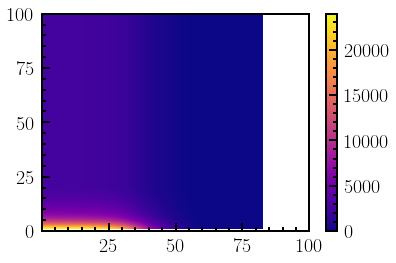

dphi-dEdt-100MeV-gn12-100s-nf_div6_0


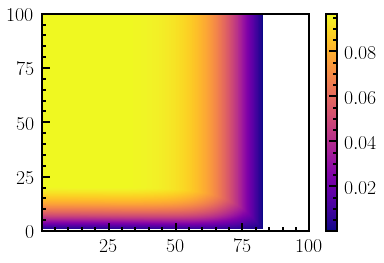

dphi-dEdt-100MeV-gn11dot4-100s-nf_div6_0


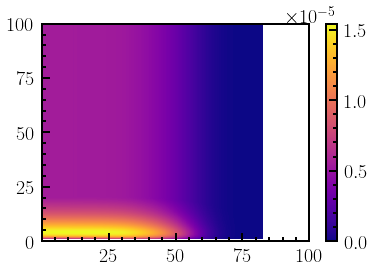

In [65]:
sm_t, sm_hits = sm_flux.get_hits()
out = {}

with h5.File("data/majoron/serialized_fluxes.h5", "r") as h5f:
    # print(h5f.keys())
    for key in "dphi-dEdt-100MeV-gn11-100s-nf_div6_0 dphi-dEdt-100MeV-gn12-100s-nf_div6_0 dphi-dEdt-100MeV-gn11dot4-100s-nf_div6_0".split():
        print(key)
        
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", ""))
        if mass not in out:
            out[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}")
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(model_file="magnetic_moment.txt")
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt"
        )
        
        
        
        plt.plot()
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
        m = ~np.isnan(significance)
        im = plt.imshow(
            significance.T[::-1],
            aspect="auto",
            extent=[
                TMINS[0] /units["second"],
                TMINS[-1] /units["second"],
                DTS[0] /units["second"],
                DTS[-1] /units["second"],
            ]
        )
        cbar = plt.colorbar(im)
        plt.show()
        
        out[mass].append((coupling, significance[m].max()))

In [181]:
try:
    dsfsdf
    tab_flux_11
except NameError:
    tab_flux_11 = massage_infile("./data/majoron/from_yingying/dphi-dEdt-100MeV-gn11-100s-nf.csv")
    
try:
    fdsfs
    tab_flux_12
except NameError:
    tab_flux_12 = massage_infile("./data/majoron/from_yingying/dphi-dEdt-100MeV-gn12-100s-nf.csv")
    
try:
    fdsfsdfds
    tab_flux_114
except NameError:
    tab_flux_114 = massage_infile("./data/majoron/from_yingying/dphi-dEdt-100MeV-gn11dot4-100s-nf.csv")

/Users/jlazar/research/ic_sn_bsm/ic_sn_hnl/flux/parametrize_flux.py:373: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  m, err = quad(f, e.min(), e.max())


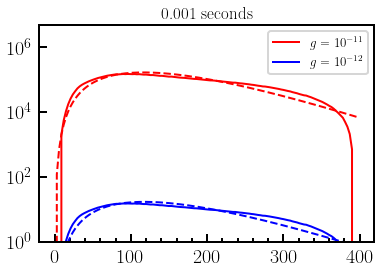

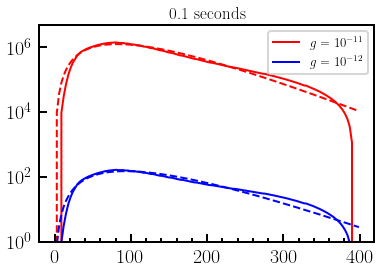

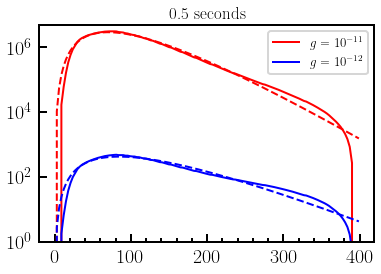

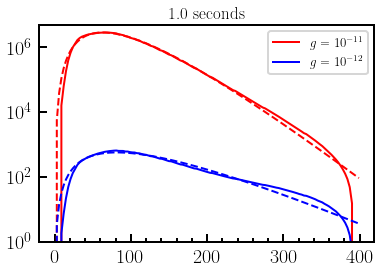

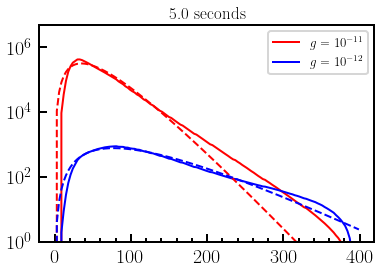

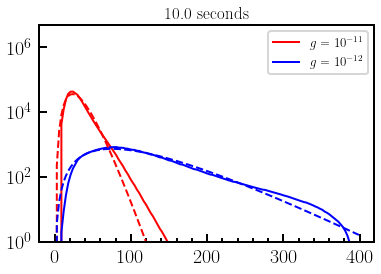

In [182]:
for idx in [1,100, 500, 1000, 5000, 10000]:
    plt.title(f"{idx / 1000} seconds", fontsize=17)
    plt.plot(tab_flux_11[idx, :, 1], tab_flux_11[idx, :, 2], label=r"$g=10^{-11}$", color="red")
    plt.plot(tab_flux_12[idx, :, 1], tab_flux_12[idx, :, 2], label=r"$g=10^{-12}$", color="blue")
    
    p1 = compute_params(tab_flux_11[idx])
    p2 = compute_params(tab_flux_12[idx])
    
    plt.plot(tab_flux_11[idx, :, 1], spectrum(p1.L, p1.e_exp, p1.alpha)(tab_flux_11[idx, :, 1]), color="red", ls="--")
    plt.plot(tab_flux_12[idx, :, 1], spectrum(p2.L, p2.e_exp, p2.alpha)(tab_flux_12[idx, :, 1]), color="blue", ls="--")
    
    plt.legend(fontsize=13)
    plt.semilogy()
    plt.ylim(1,5e6)
    plt.show()

In [171]:
sm_t, sm_hits = sm_flux.get_hits()
# out = {}

with h5.File("data/majoron/serialized_fluxes_double_old.h5", "r") as h5f:
    for key in h5f.keys():
        print(key)
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", ""))
        
        if mass!=100:
            continue
        
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}")
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(model_file="magnetic_moment.txt")
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt"
        )
        
        print(coupling, bsm_hits.sum())
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
#         significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
#         m = ~np.isnan(significance)
#         im = plt.imshow(
#             significance.T[::-1],
#             aspect="auto",
#             extent=[
#                 TMINS[0] /units["second"],
#                 TMINS[-1] /units["second"],
#                 DTS[0] /units["second"],
#                 DTS[-1] /units["second"],
#             ]
#         )
#         cbar = plt.colorbar(im)
#         plt.show()
        
#         out[mass].append((coupling, significance[m].max()))

dphi-dEdt-100MeV-gn11-100s-nf_div6_0
-11.0 283562.83958756016
dphi-dEdt-100MeV-gn11dot4-100s-nf_div6_0
-11.4 12.818651414071303
dphi-dEdt-100MeV-gn11dot6-100s-nf_div6_0
-11.6 4.88583207193141
dphi-dEdt-100MeV-gn11dot8-100s-nf_div6_0
-11.8 1.5419597374185545
dphi-dEdt-100MeV-gn12-100s-nf_div6_0
-12.0 1705.5071202440386
dphi-dEdt-1MeV-gn10-100s-nf_div6_0
dphi-dEdt-1MeV-gn9-100s-nf_div6_0
dphi-dEdt-200MeV-gn11-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot4-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot6-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot8-100s-nf_div6_0
dphi-dEdt-200MeV-gn12-100s-nf_div6_0


In [151]:
with h5.File("./data/majoron/serialized_fluxes_double_old.h5", "r") as h5f:
    # pass
    npts = len([k for k in h5f.keys() if "100MeV" in k])
    times = np.zeros((npts, 1001))
    params = np.zeros((npts, 4, 1001))
    couplings = []
    print(npts)
    idx = 0
    for key in h5f.keys():
        print(key)
        if "100MeV" not in key:
            continue
#         mass = 100
        key_split = key.split("_")[0].split("-")
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}")
        couplings.append(coupling)
        times[idx, :] = h5f[key]["times"][:]
        params[idx, :, :] = h5f[key]["params"][0, :, :]
        idx += 1
        
couplings = np.array(couplings)
sorter = np.argsort(-couplings)
times = times[sorter]
params = params[sorter]
couplings = couplings[sorter]

5
dphi-dEdt-100MeV-gn11-100s-nf_div6_0
dphi-dEdt-100MeV-gn11dot4-100s-nf_div6_0
dphi-dEdt-100MeV-gn11dot6-100s-nf_div6_0
dphi-dEdt-100MeV-gn11dot8-100s-nf_div6_0
dphi-dEdt-100MeV-gn12-100s-nf_div6_0
dphi-dEdt-1MeV-gn10-100s-nf_div6_0
dphi-dEdt-1MeV-gn9-100s-nf_div6_0
dphi-dEdt-200MeV-gn11-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot4-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot6-100s-nf_div6_0
dphi-dEdt-200MeV-gn11dot8-100s-nf_div6_0
dphi-dEdt-200MeV-gn12-100s-nf_div6_0


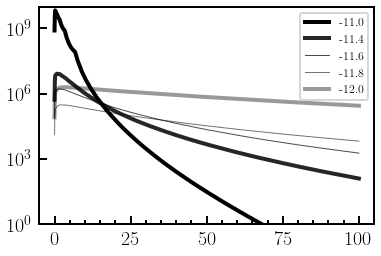

In [157]:
alpha = 1

for idx in range(npts):
    coupling = couplings[idx]
    lw=4
    
    if coupling not in [-11, -11.4, -12]:
        lw=1
    plt.plot(times[idx], params[idx, 0, :], alpha=alpha, color="k", label=coupling, lw=lw)
    alpha -= 0.15
plt.legend(fontsize=12)
plt.semilogy()
plt.ylim(1, 1e10)
plt.show()


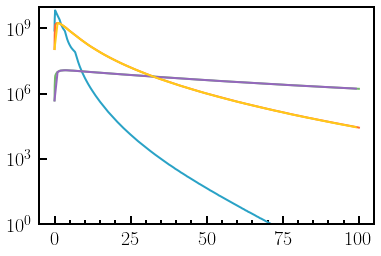

In [185]:
de = 3
plt.plot(
    tab_flux_11[:, 0,0],
    de / 6 *(tab_flux_11[:, :, 1] * tab_flux_11[:, :, 2]).sum(axis=1)
)
plt.plot(
    tab_flux_114[:, 0,0],
    de / 6 *(tab_flux_114[:, :, 1] * tab_flux_114[:, :, 2]).sum(axis=1)
)
plt.plot(
    tab_flux_12[:, 0,0],
    de / 6 *(tab_flux_12[:, :, 1] * tab_flux_12[:, :, 2]).sum(axis=1)
)
plt.plot(range(100), b)
plt.plot(range(100), a)

plt.semilogy()
plt.ylim(1, 1e10)

plt.show()

In [184]:
a = []
b = []
for idx in tqdm(range(100)):
    idx *=1000
    a.append(compute_moment(tab_flux_114[idx], 1))
    b.append(compute_moment(tab_flux_12[idx], 1))
    

100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


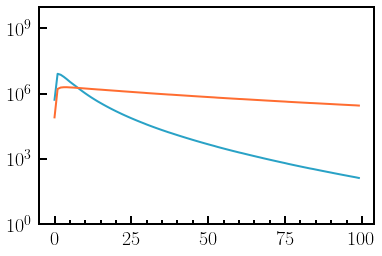

In [176]:
plt.plot(range(100), a)
plt.plot(range(100), b)

plt.semilogy()
plt.ylim(1, 1e10)

plt.show()

In [141]:
compute_params(tab_flux_114[5000])

/Users/jlazar/research/ic_sn_bsm/ic_sn_hnl/flux/parametrize_flux.py:373: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


Params(L=757760716.1255203, e_exp=82.09346842031253, rms=91.79260965785096, alpha=2.9959414292229947)

In [188]:
a1 = massage_infile("./data/majoron/per_flavor/dphi-dEdt-100MeV-gn11dot4-100s-nf_div6.csv")
a2 = massage_infile("./data/majoron/from_yingying/dphi-dEdt-100MeV-gn11dot4-100s-nf.csv")


In [191]:
a1

array([[[1.00000e-03, 0.00000e+00, 0.00000e+00],
        [1.00000e-03, 5.00000e-01, 0.00000e+00],
        [1.00000e-03, 1.00000e+00, 0.00000e+00],
        ...,
        [1.00000e-03, 6.55000e+01, 0.00000e+00],
        [1.00000e-03, 6.60000e+01, 0.00000e+00],
        [1.00000e-03, 6.65000e+01, 0.00000e+00]],

       [[2.00000e-03, 0.00000e+00, 0.00000e+00],
        [2.00000e-03, 5.00000e-01, 0.00000e+00],
        [2.00000e-03, 1.00000e+00, 0.00000e+00],
        ...,
        [2.00000e-03, 6.55000e+01, 0.00000e+00],
        [2.00000e-03, 6.60000e+01, 0.00000e+00],
        [2.00000e-03, 6.65000e+01, 0.00000e+00]],

       [[3.00000e-03, 0.00000e+00, 0.00000e+00],
        [3.00000e-03, 5.00000e-01, 0.00000e+00],
        [3.00000e-03, 1.00000e+00, 0.00000e+00],
        ...,
        [3.00000e-03, 6.55000e+01, 0.00000e+00],
        [3.00000e-03, 6.60000e+01, 0.00000e+00],
        [3.00000e-03, 6.65000e+01, 0.00000e+00]],

       ...,

       [[9.99990e+01, 0.00000e+00, 0.00000e+00],
        [9.

/Users/jlazar/research/ic_sn_bsm/ic_sn_hnl/flux/parametrize_flux.py:373: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  m, err = quad(f, e.min(), e.max())


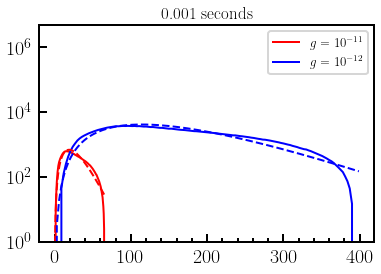

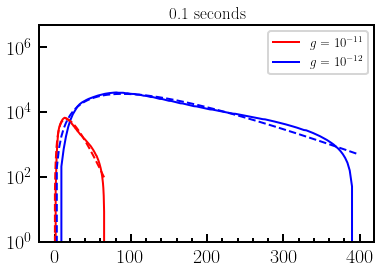

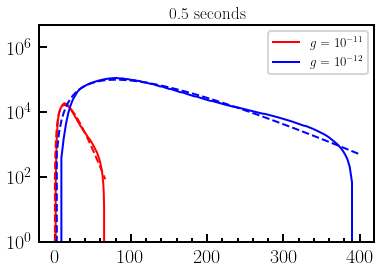

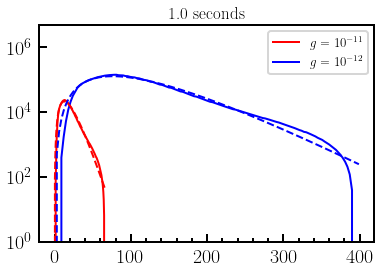

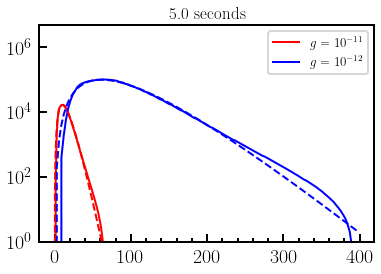

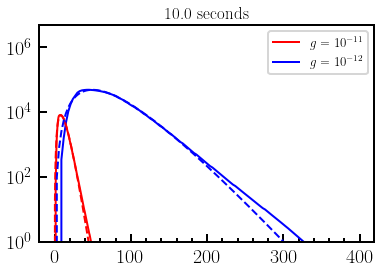

In [189]:
for idx in [1,100, 500, 1000, 5000, 10000]:
    plt.title(f"{idx / 1000} seconds", fontsize=17)
    plt.plot(a1[idx, :, 1], a1[idx, :, 2], label=r"$g=10^{-11}$", color="red")
    plt.plot(a2[idx, :, 1], a2[idx, :, 2], label=r"$g=10^{-12}$", color="blue")
    
    p1 = compute_params(a1[idx])
    p2 = compute_params(a2[idx])
    
    plt.plot(a1[idx, :, 1], spectrum(p1.L, p1.e_exp, p1.alpha)(a1[idx, :, 1]), color="red", ls="--")
    plt.plot(a2[idx, :, 1], spectrum(p2.L, p2.e_exp, p2.alpha)(a2[idx, :, 1]), color="blue", ls="--")
    
    plt.legend(fontsize=13)
    plt.semilogy()
    plt.ylim(1,5e6)
    plt.show()

In [284]:
np.savetxt("./text.txt", outarr, delimiter=",")

In [285]:
np.save("./text.npy", outarr)

In [ ]:
parameterized_flux_from_txt_files